## MBNMS Upper Heat Content Analysis ##
Using the 4DVars ROMS model from UCSC, Upper Heat Content is calculated as the integral of temperature from 0-100 meters multiplied by the a constant.

Steps:
1. ROMS Data are pulled from the UCSC TDS (THREDDS Data Server)
    1. Data are masked to the boundary of the Monterey Bay National Marine Sanctuary
    2. Converted into discrete depth bins (from sigma coordinates)
2. The __Heat Content__ for the upper 100 meters is calculated
3. Those data are __Spatially Summed__ to for the region to make a time series

In [4]:
import numpy as np
import xarray as xr
from set_depth import set_depth
import cmocean
from shapely.geometry import Polygon, Point
from matplotlib.path import Path
import scipy.io
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import salem
from scipy import integrate
import pandas as pd

Data are accessed through http://oceanmodeling.pmc.ucsc.edu:8080/thredds using `xarray.open_dataset()`

In [5]:
url = 'http://oceanmodeling.pmc.ucsc.edu:8080/thredds/dodsC/ccsra_2016a_phys_agg_slevs/fmrc/CCSRA_2016a_Phys_ROMS_Sigma-level_Aggregation_best.ncd'
roms_ds = xr.open_dataset(url)

## Convert the depth coordinates ##
Stretching Information

In [6]:
s_coor_streching_rho = roms_ds['Cs_r'].values # S-coordinate stretching curves at RHO-points
s_coor_streching_w = roms_ds['Cs_w'].values # S-coordinate stretching curves at w-points
vertical_stretching_function = roms_ds['Vstretching'] # vertical terrain following stretching function
vertical_transformation_function = roms_ds['Vtransform'] # vertical terrain following tranformation equation

In [7]:
h = roms_ds['h'] # bathymetry at rho points
h_critical = roms_ds['hc'] # S-coordinate parameter, critical depth
theta_bottom = roms_ds['theta_b'].values # S-coordinate bottom control parameter
theta_surface = roms_ds['theta_s'].values # S-coordinate surface control parameter
zeta = roms_ds['zeta'] # free surface
N_levels=42 # number of levels, note w has 43 levels
zeta = np.squeeze(zeta[0,:,:]) # reduce dimensions to

__Calculate z-depths for rho points__

In [ ]:
%%time
igrid=1 # density point grid, for (T,S) use igrid=3, for u and igrid=4 for v # use igrid=5 for w
z_rho = set_depth(vertical_transformation_function, vertical_stretching_function, theta_surface, theta_bottom, h_critical, N_levels, igrid, h, zeta, report=0)

__Calculate z-depths for stream functions points__

In [ ]:
%%time
igrid=2 # density point grid, for (T,S) use igrid=3, for u and igrid=4 for v # use igrid=5 for w
z_stream = set_depth(vertical_transformation_function, vertical_stretching_function, theta_surface, theta_bottom, h_critical, N_levels, igrid, h, zeta, report=0)

Transpose to the shape we want so z is the third axis<br>
This will now have the shape of as the z data

## Interpolate Temperature to a grid ##
- Take a subset of the ROMS Dataset to work with
- Calculate z-depths with the stretching functions
- At each point interpolate to the nearest z-depth bin


There is a lot going on here, but the idea is to replace the `eta_rho` and `xi_rho` index based dimension with the latitudes and longitudes coordinates, since xarray can handle these natively

In [ ]:
roms_ds = xr.open_dataset(url)
roms_temp = roms_ds['temp']
roms_temp_latitude = roms_temp['lat_rho'].values[:,0]
roms_temp_longitude = roms_temp['lon_rho'].values[0,:]
roms_temp = roms_temp.assign_coords({"eta_rho":roms_temp_latitude, "xi_rho":roms_temp_longitude})
roms_temp = roms_temp.rename({"eta_rho":"latitude", "xi_rho":"longitude"})
roms_temp = roms_temp.drop('lat_rho', errors='ignore')
roms_temp = roms_temp.drop('lon_rho', errors='ignore')
roms_temp = roms_temp.drop('time_run', errors='ignore')
roms_temp = roms_temp.transpose('time','latitude','longitude','s_rho')
roms_temp['z_rho'] = (('latitude','longitude','s_rho'),z_rho) # Add the depth values back to the Dataset

In [328]:
def calculate_upper_heat_content(temperature, upper_depth=-100 ):
    """ 
    Calculate upper ocean heat content from ROMS
    
    Calculate the upper ocean heat (J/m^2) content from the CA ROMS model output
    Density is assumed constant at 1025 kg/m^3
    specific heat is 3850 J/(kg C)
    Args:
        temperature: xarray dataset with dimensions (latitude,longitude,s_sho) 
        z_rho: array mapping sigma depth bins to depths in meters with dimensions (latitude,longitude,s_sho) 
        upper_depth: depth to integrate to from the surface, values below the surface are negative

    Returns:
        upper_heat_content: array of upper heat content values in the shape of the temperature input dimensions (latitude, longitude)
        upper_heat_content_b_bins: array of the number of depth bins used for integrated upper heat content in the shape of the temperature input dimensions (latitude, longitude)
    """
    z_rho = temperature.z_rho.values
    cp = 3850
    density = 1025
    
    if len(z_rho.shape) == 1:
        '''Calculating at single point'''
        upper_heat_content = np.zeros(shape=(1))
        upper_heat_content_n_bins = np.zeros(shape=(1))
        roms_temperature_flattened = temperature.values.reshape(-1, temperature.shape[-1])
        
    else:
        upper_heat_content = np.zeros(shape=(z_rho.shape[0]*z_rho.shape[1]))
        upper_heat_content_n_bins = np.zeros(shape=(z_rho.shape[0]*z_rho.shape[1]))
        roms_temperature_flattened = temperature.values.reshape(-1, temperature.shape[-1])
    for i, grid_point in enumerate(z_rho.reshape(-1, z_rho.shape[-1])):
        #Find index of depth less than 100 meters
        upper_ix = np.where(grid_point >= upper_depth)[0]
        # Integrate
        if not upper_ix.size == 0:
            integrated_temp = integrate.simps(roms_temperature_flattened[i,upper_ix], grid_point[upper_ix])
            upper_heat_content[i] = density * cp * integrated_temp
            upper_heat_content_n_bins[i] = len(upper_ix)
        else:
            upper_heat_content[i] = np.nan
            upper_heat_content_n_bins[i] = np.nan
    
    if len(z_rho.shape) == 1:
        return upper_heat_content, upper_heat_content_n_bins
    else:
        upper_heat_content = upper_heat_content.reshape(z_rho.shape[:2])
        upper_heat_content_n_bins = upper_heat_content_n_bins.reshape(z_rho.shape[:2])
        return upper_heat_content, upper_heat_content_n_bins

## Testing out the function with M1 data

This is pretty slow still ~30 mintues because the integration needs to be looped and the data has to checked up at each timestep

In [ ]:
import time

In [361]:
%%time
m1_temp = roms_temp.sel(latitude=36.75,longitude= -122, method="nearest")
m1_heat_content = np.zeros(shape=m1_temp.time.shape)
for i in range(len(m1_heat_content)):
    if i == 0:
        start_time = time.time()
        
    upper_heat_content, upper_heat_content_n_bins = calculate_upper_heat_content(m1_temp.isel(time=i), upper_depth=-100)
    m1_heat_content[i] = upper_heat_content
    if i%100 == 0:
        print(i,round(time.time()-start_time,1),'s')
        start_time = time.time()
        

0 0.4 s
100 34.6 s
200 35.9 s
300 35.3 s
400 31.2 s
500 35.6 s
600 41.0 s
700 43.0 s
800 34.5 s
900 33.8 s
1000 31.6 s
1100 38.5 s
1200 32.8 s
1300 30.7 s
1400 39.9 s
1500 33.7 s
1600 32.7 s
1700 37.2 s
1800 42.8 s
1900 31.8 s
2000 43.5 s
2100 33.9 s
2200 42.8 s
2300 46.7 s
2400 56.4 s
2500 69.3 s
2600 61.5 s
2700 59.8 s
2800 63.3 s
2900 66.5 s
3000 59.1 s
3100 65.3 s
3200 57.5 s
CPU times: user 9.77 s, sys: 857 ms, total: 10.6 s
Wall time: 23min 34s


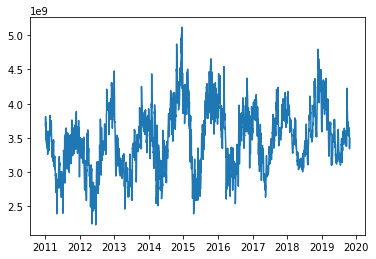

In [362]:
fig, ax = plt.subplots()
times = m1_temp.time.values
ax.plot(times, m1_heat_content)

__Push to pandas and save a csv for posterity__

In [447]:
roms_heat = pd.DataFrame(columns=['dateTime','heatContent'])
roms_heat['dateTime'] = m1_temp.time
roms_heat['heatContent'] = m1_heat_content
roms_heat.index = roms_heat['dateTime']
roms_heat.to_csv('roms_m1_heat_content.csv')